Libraries

In [2]:
import cv2,sys,dlib,time,math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../resource/lib/public')
import faceBlendCommon as fbc

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0,8.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

Landmark detector

In [3]:
# Landmark model location
PREDICTOR_PATH =  "../resource/lib/publicdata/models/shape_predictor_68_face_landmarks.dat"

# Get the face detector
faceDetector = dlib.get_frontal_face_detector()
# The landmark detector is implemented in the shape_predictor class
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

Load Image

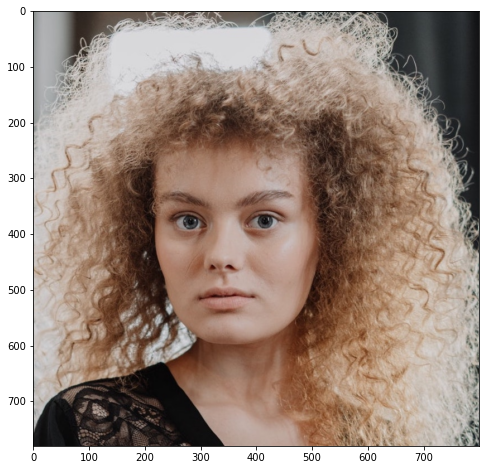

In [5]:
im = cv2.imread("../resource/lib/publicdata/images/girl-no-makeup.jpg")
imDlib = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
plt.imshow(imDlib)

Extract Land Marks

In [6]:
points = fbc.getLandmarks(faceDetector, landmarkDetector, imDlib)
print(points)

[(216, 375), (217, 411), (224, 446), (233, 480), (242, 515), (258, 547), (283, 574), (313, 594), (350, 600), (390, 595), (430, 579), (464, 557), (488, 524), (501, 487), (508, 447), (513, 408), (514, 369), (223, 343), (241, 326), (268, 325), (293, 333), (317, 346), (362, 345), (389, 331), (418, 321), (449, 321), (474, 336), (338, 374), (337, 397), (335, 419), (333, 442), (315, 465), (326, 468), (337, 471), (351, 468), (364, 465), (252, 378), (268, 368), (289, 369), (307, 385), (287, 390), (266, 389), (382, 384), (401, 369), (423, 367), (441, 375), (426, 387), (404, 389), (293, 517), (310, 503), (327, 496), (340, 500), (353, 496), (376, 502), (401, 514), (377, 528), (356, 535), (341, 536), (326, 535), (310, 530), (303, 516), (327, 512), (340, 512), (354, 511), (391, 513), (354, 512), (341, 513), (327, 513)]


Plot Land Marks

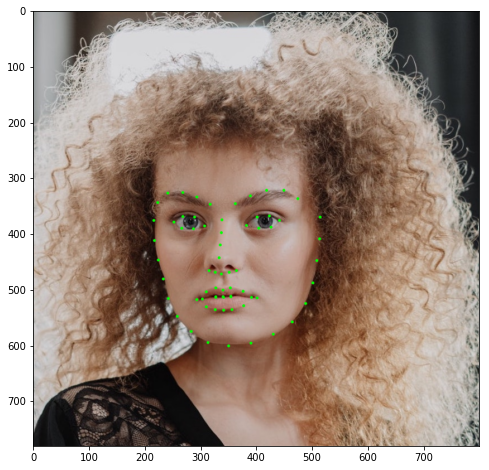

In [10]:
land_mark = imDlib.copy()
for p in points:
    land_mark = cv2.circle(land_mark, p, radius=1, color=(0, 255, 0), thickness=2)
plt.imshow(land_mark)

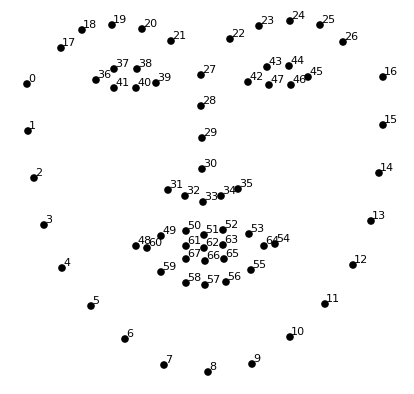

Extract only the polygon of the eyes

In [11]:
def eyes_shape(shape, mask, side):
    filtered = [shape[i] for i in side]
    filtered = np.array(filtered, dtype=np.int32)
    mask = cv2.fillConvexPoly(mask, filtered, 255)
    return mask

In [12]:
def get_eyes_mask(points,imDlib):
    mask = np.zeros(imDlib.shape[:2], dtype=np.uint8)
    left = [36, 37, 38, 39, 40, 41]
    right = [42, 43, 44, 45, 46, 47]
    mask = eyes_shape(points, mask, left)
    mask = eyes_shape(points, mask, right)
    return mask

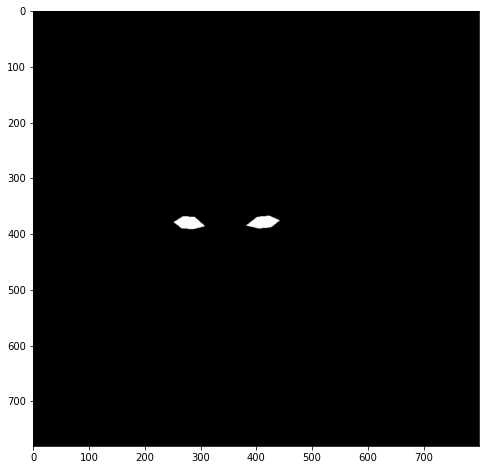

In [13]:
eyes_mask = get_eyes_mask(points,imDlib)
plt.imshow(eyes_mask)

The RGB of the image (the real eyes)

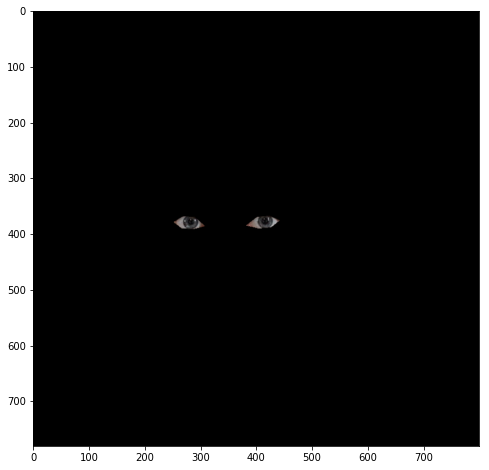

In [14]:
rgb_eyes = cv2.bitwise_and(imDlib, imDlib, mask=eyes_mask)
plt.imshow(rgb_eyes)

In [15]:
def eye_operations(points,side,rgb_both_eyes,color_name):
    coord = coord_eyes(points,side)
    rgb_one_eye = cut_eye_area(rgb_both_eyes,coord)
    #plt.imshow(rgb_one_eye)

    eye_bin = get_iris_mask(rgb_one_eye)
    #plt.imshow(eye_bin)

    back_eye = np.copy(rgb_one_eye)
    back_eye[eye_bin != 0] = [0, 0, 0]
    #plt.imshow(back_eye)

    front_eye = np.copy(rgb_one_eye)
    front_eye[eye_bin == 0] = [0, 0, 0]
    #plt.imshow(front_eye)
    new_front_eye = change_color(front_eye,color_name)
    #plt.imshow(new_front_eye)

    new_eye = back_eye + new_front_eye
    #plt.imshow(new_eye)
    return [coord,new_eye]

In [16]:
def coord_eyes(points,side):
    span_y = 5
    span_x = 15
    if side == 'right':
        x1 = min(points[43][0],points[47][0])-span_x
        x2 = max(points[46][0],points[44][0])+span_x
        y1 = min(points[43][1],points[44][1])-span_y
        y2 = max(points[46][1],points[47][1])+span_y
    elif side == 'left':
        x1 = min(points[37][0],points[41][0])-span_x
        x2 = max(points[40][0],points[38][0])+span_x
        y1 = min(points[37][1],points[38][1])-span_y
        y2 = max(points[40][1],points[41][1])+span_y
    return [[y1,y2],[x1,x2]]

In [17]:
def cut_eye_area(eyes,coord):
    y = coord[0]
    x = coord[1]
    mask = (eyes == [0, 0, 0]).all(axis=2)
    eyes[mask] = [255, 255, 255]
    return eyes[y[0]:y[1],x[0]:x[1]]

Extract the area of the eye

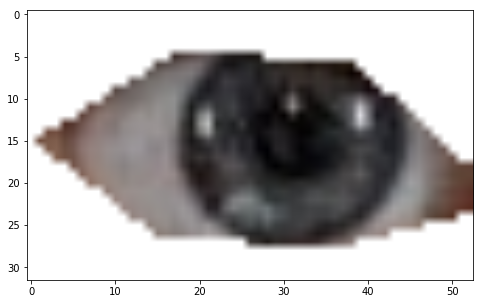

In [23]:
coord = coord_eyes(points,'left')
rgb_one_eye = cut_eye_area(rgb_eyes,coord)
plt.imshow(rgb_one_eye)

In [21]:
def get_iris_mask(just_eye):
    thd_iris = 90
    frame_HSV = cv2.cvtColor(just_eye, cv2.COLOR_BGR2HSV)
    _, thresh_gray = cv2.threshold(frame_HSV[:,:,2], 
                                   thd_iris, 255, cv2.THRESH_BINARY_INV)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    opening = cv2.morphologyEx(thresh_gray, cv2.MORPH_OPEN, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    
    return closing

Mask of the iris and pupil from the eye 

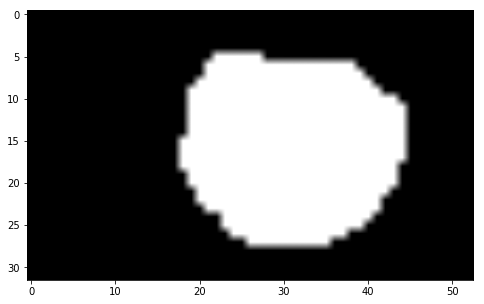

In [24]:
eye_bin = get_iris_mask(rgb_one_eye)
plt.imshow(eye_bin)

The white part of the eye

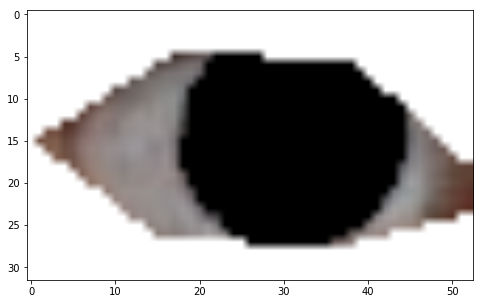

In [25]:
back_eye = np.copy(rgb_one_eye)
back_eye[eye_bin != 0] = [0, 0, 0]
plt.imshow(back_eye)

Separate iris and pupil from the eye

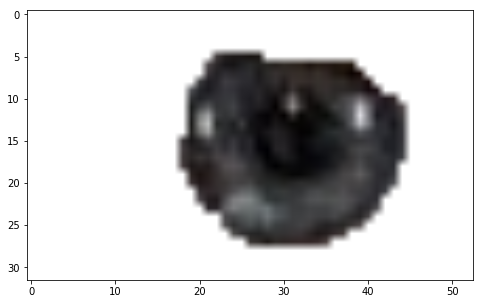

In [32]:
front_eye = np.copy(rgb_one_eye)
front_eye[eye_bin == 0] = [255, 255, 255]
plt.imshow(front_eye)
front_eye[eye_bin == 0] = [0, 0, 0]

In [33]:
def change_color(original,color_name):
    # pivot points for X-Coordinates
    originalValue = np.array([0, 50, 100, 150, 200, 255])
    img = np.copy(original)

    if color_name == 'brown':
        curve = np.array([0, 80, 150, 190, 220, 255])
        channel_ix = 0
    elif color_name == 'green':
        curve = np.array([0, 100,  150, 162, 175, 200])
        channel_ix = 1
    elif color_name == 'blue':
        curve = np.array([0, 100,  150, 180, 195, 200])
        channel_ix = 2
     
    # Create a LookUp Table
    fullRange = np.arange(0,256)
    LUT = np.interp(fullRange, originalValue, curve )
    
    Channel = original[:,:,channel_ix]
    Channel = cv2.LUT(Channel, LUT)
    img[:,:,channel_ix] = Channel
    
    return img

Change color with Tone Adjustment

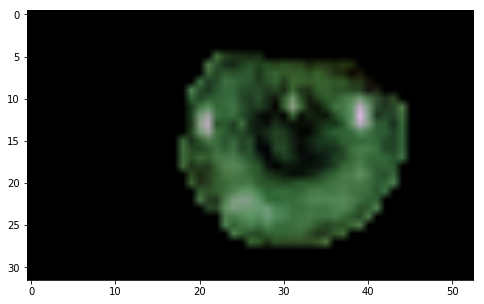

In [34]:
new_front_eye = change_color(front_eye,'green')
plt.imshow(new_front_eye)

Merge the new iris and pupil with the white part

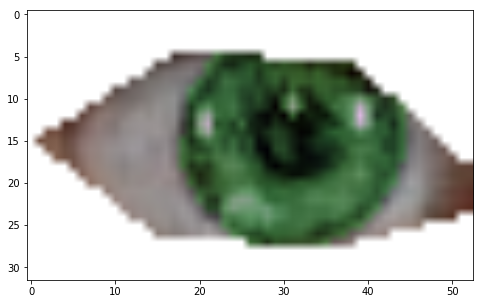

In [35]:
new_eye = back_eye + new_front_eye
plt.imshow(new_eye)

Experiment with a different color in the other eye

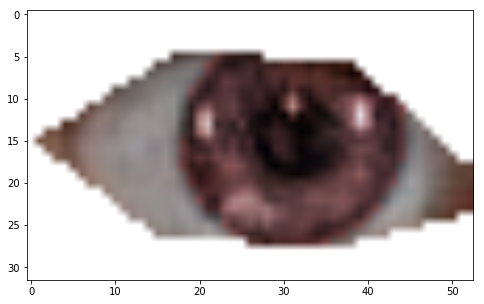

In [39]:
[coord_right,new_eye_right] = eye_operations(points,'right',rgb_eyes,'green')
[coord_left,new_eye_left] = eye_operations(points,'left',rgb_eyes,'brown')
plt.imshow(new_eye_left)

In [40]:
def replace_eyes(rgb_eyes,coord_right,new_eye_right,coord_left,new_eye_left):
    y_r = coord_right[0]
    x_r = coord_right[1]
    rgb_eyes[y_r[0]:y_r[1],x_r[0]:x_r[1]] = new_eye_right
    y_l = coord_left[0]
    x_l = coord_left[1]
    rgb_eyes[y_l[0]:y_l[1],x_l[0]:x_l[1]] = new_eye_left
    return rgb_eyes

Return both eyes to the original image

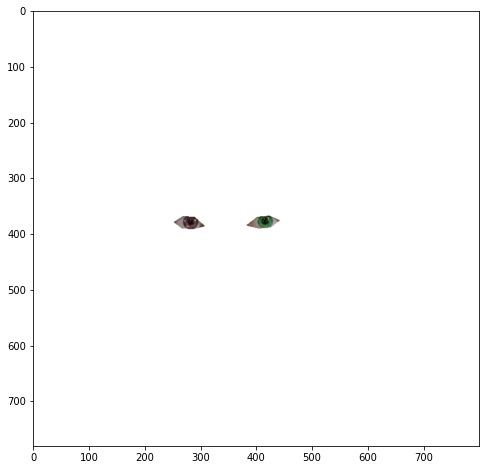

In [42]:
rgb_eyes = replace_eyes(rgb_eyes,coord_right,new_eye_right,coord_left,new_eye_left)
plt.imshow(rgb_eyes)

Creepy image without eyes

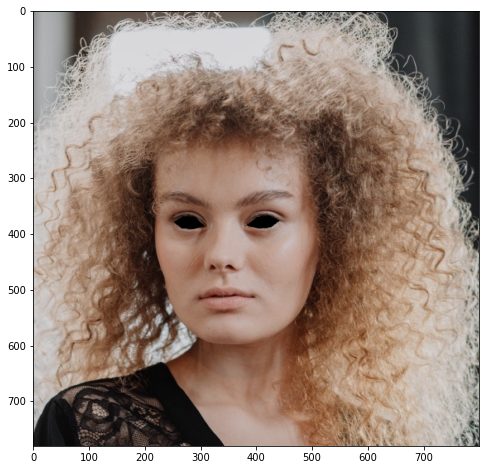

In [48]:
back_rgb_eyes = cv2.bitwise_and(imDlib, imDlib, mask=(255-eyes_mask))
plt.imshow(back_rgb_eyes)
new_color = back_rgb_eyes + rgb_eyes

Finally compare the original color with the new eyes

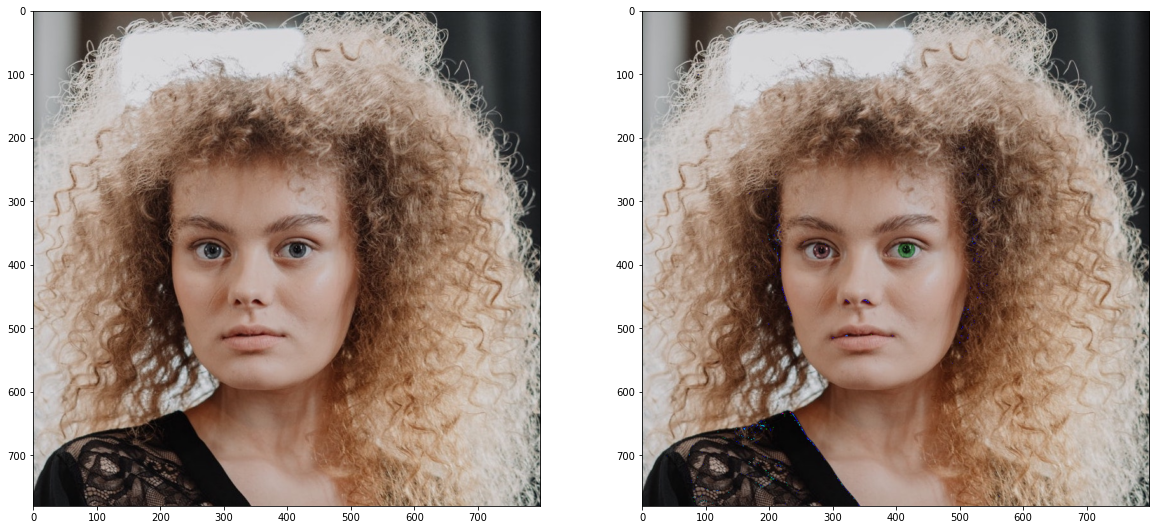

In [47]:
fig=plt.figure(figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(imDlib)
fig.add_subplot(1, 2, 2)
plt.imshow(new_color)
plt.show()